# Sagemaker構築サンプル

MNISTを使用して、１桁の手書き数字の画像データセットを、SageMakerの組み込みのK-Meansで分類してみる。

## ロールとバケットの設定

In [1]:
from sagemaker import get_execution_role
 
role = get_execution_role()

# S3バケット名を指定
bucket='sagemaker-getting-started-ml' 

## MINSTデータセットの読み込み

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json
 
# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 847 ms, sys: 309 ms, total: 1.16 s
Wall time: 8.45 s


## トレーニングデータセットの調査

In [3]:
print(train_set[0].shape,train_set[1].shape)
print(valid_set[0].shape, valid_set[1].shape)
print(test_set[0].shape, test_set[1].shape)

(50000, 784) (50000,)
(10000, 784) (10000,)
(10000, 784) (10000,)


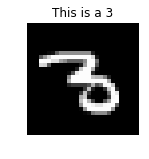

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)
 
 
def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)
 
show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## トレーニングデータセットの変換とS3へのアップロード

モデルの学習を効率良く行うために、通常、ダウンロードしたMNISTデータセットを numpy.array フォーマットから RecordIO protobuf フォーマットに変換する。（今回は、SageMaker 用の Python ライブラリを使用するため、変換はしない）

RecordIO protobuf フォーマットは、SageMakerの全ての組み込みアルゴリズムでnumpy.arrayフォーマットよりも効率良くデータを扱うことができるフォーマットらしい。

## 入出力先（S3）の設定¶

In [5]:
from sagemaker import KMeans
 
# 入力元
data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)

# 出力先
output_location = 's3://{}/kmeans_example/output'.format(bucket)
 
print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

training data will be uploaded to: s3://sagemaker-getting-started-ml/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-getting-started-ml/kmeans_example/output


## K-meansによる学習

In [6]:
# warningを非表示
import warnings
warnings.filterwarnings('ignore')

# モデル作成
kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
#                 train_instance_type='m4.xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

# 学習
kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-12-03-10-45-12-933


2018-12-03 10:45:13 Starting - Starting the training job...
2018-12-03 10:45:14 Starting - Launching requested ML instances.........
2018-12-03 10:46:47 Starting - Preparing the instances for training......
2018-12-03 10:47:55 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[12/03/2018 10:48:23 INFO 140440491001664] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[12/03/2


2018-12-03 10:48:36 Training - Training image download completed. Training in progress.
2018-12-03 10:48:36 Uploading - Uploading generated training model
2018-12-03 10:48:36 Completed - Training job completed
Billable seconds: 81


## Amazon SageMaker ホスティングサービスにモデルをデプロイする

トレーニングしたモデルをエンドポイント（どこ？）にデプロイする。

In [7]:
%%time
 
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-12-03-10-51-07-245
INFO:sagemaker:Creating endpoint with name kmeans-2018-12-03-10-45-12-933


---------------------------------------------------------------!CPU times: user 332 ms, sys: 15.4 ms, total: 348 ms
Wall time: 5min 20s


### エラー対策

    ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'ml.m4.xlarge for endpoint usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.
    
と出力されている場合は、AWSサポートに制限を緩和して`ml.m4.xlarge`を使用できるようにしてもらう必要がある。

制限緩和の方法は
[Amazon SageMakerでml.p2.xlargeを使おうとしたらResourceLimitExceededって怒られた](https://qiita.com/okazy/items/b32e552cf36c3c815810)
を参照。同じリージョンなら１営業日くらいで制限を緩和してくれる。


## モデルの検証

In [9]:
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 7.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.721954822540283
    }
  }
}
]


valid_setデータセットの30番目の画像に対する推論結果が、クラスター7に属していることが分かる。

    key:"closest_cluster"
      value {
        float32_tensor {
          values: 7.0
        }

valid_setデータセットの先頭から100個分の推論結果を取得してみる。

In [10]:
%%time 
 
result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 34.1 ms, sys: 4 µs, total: 34.1 ms
Wall time: 197 ms





Cluster 0:


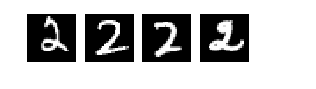




Cluster 1:


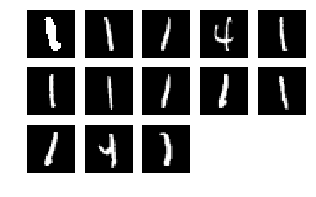




Cluster 2:


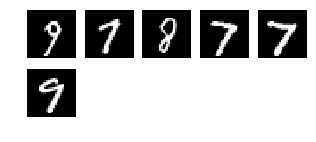




Cluster 3:


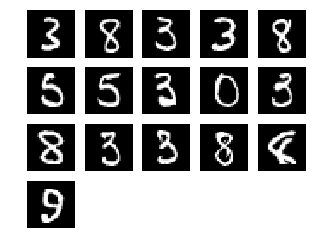




Cluster 4:


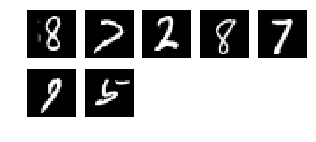




Cluster 5:


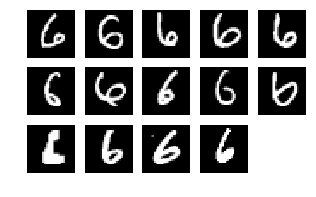




Cluster 6:


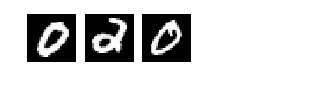




Cluster 7:


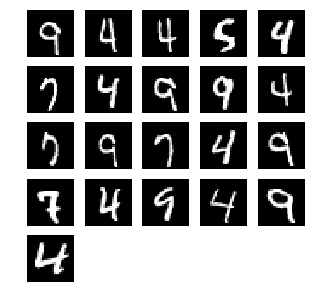




Cluster 8:


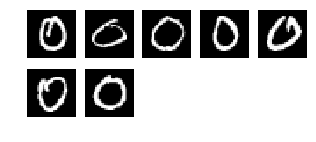




Cluster 9:


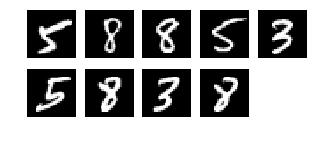

In [11]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5) + 1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')
 
    plt.show()

うーん微妙・・・

valid_setデータセットの30番目の画像に対する推論結果を再確認

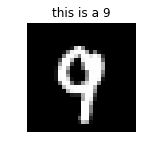

In [21]:
show_digit(valid_set[0][30], 'this is a {}'.format(valid_set[1][30]))